# Road Traffic Fine Management

## Setup

In [114]:
import pandas as pd
import pm4py
import numpy as np

In [115]:
log_raw = pm4py.read_xes("Road_Traffic_Fine_Management_Process.xes")

parsing log, completed traces ::   0%|          | 0/150370 [00:00<?, ?it/s]

In [116]:
log_raw = pm4py.format_dataframe(log_raw, case_id='case:concept:name', activity_key='concept:name', timestamp_key='time:timestamp')
log_raw['time:timestamp'] = pd.to_datetime(log_raw['time:timestamp'])

log_raw.head(7)

,amount,org:resource,dismissal,concept:name,vehicleClass,totalPaymentAmount,lifecycle:transition,time:timestamp,article,points,case:concept:name,expense,notificationType,lastSent,paymentAmount,matricola,@@index,@@case_index
0,35.0,561,NIL,Create Fine,A,0.0,complete,2006-07-24 00:00:00+00:00,157.0,0.0,A1,NaN,NaN,NaN,NaN,NaN,0,0
1,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2006-12-05 00:00:00+00:00,NaN,NaN,A1,11.0,NaN,NaN,NaN,NaN,1,0
2,35.0,561,NIL,Create Fine,A,0.0,complete,2006-08-02 00:00:00+00:00,157.0,0.0,A100,NaN,NaN,NaN,NaN,NaN,2,1
3,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2006-12-12 00:00:00+00:00,NaN,NaN,A100,11.0,NaN,NaN,NaN,NaN,3,1
4,NaN,NaN,NaN,Insert Fine Notification,NaN,NaN,complete,2007-01-15 00:00:00+00:00,NaN,NaN,A100,NaN,P,P,NaN,NaN,4,1
5,71.5,NaN,NaN,Add penalty,NaN,NaN,complete,2007-03-16 00:00:00+00:00,NaN,NaN,A100,NaN,NaN,NaN,NaN,NaN,5,1
6,NaN,NaN,NaN,Send for Credit Collection,NaN,NaN,complete,2009-03-30 00:00:00+00:00,NaN,NaN,A100,NaN,NaN,NaN,NaN,NaN,6,1


In [117]:
# Raw log analysis

num_events = len(log_raw)
num_cases = len(log_raw['case:concept:name'].unique())
print(f"Number of events: {num_events}\nNumber of cases: {num_cases}")

start_activities = pm4py.get_start_activities(log_raw)
end_activities = pm4py.get_end_activities(log_raw)
all_activities = log_raw["concept:name"].unique().tolist()
print(f"Start activities: {start_activities}\nEnd activities: {end_activities}\nAll activites: {all_activities}")

Number of events: 561470
Number of cases: 150370
Start activities: {'Create Fine': 150370}
End activities: {'Send Fine': 20755, 'Send for Credit Collection': 58997, 'Payment': 67201, 'Send Appeal to Prefecture': 3144, 'Appeal to Judge': 134, 'Notify Result Appeal to Offender': 86, 'Receive Result Appeal from Prefecture': 53}
All activites: ['Create Fine', 'Send Fine', 'Insert Fine Notification', 'Add penalty', 'Send for Credit Collection', 'Payment', 'Insert Date Appeal to Prefecture', 'Send Appeal to Prefecture', 'Receive Result Appeal from Prefecture', 'Notify Result Appeal to Offender', 'Appeal to Judge']


## Data Cleaning

### NaN values

Check which columns have NaN values

In [118]:
log_df = log_raw.copy()

for col in log_df:
    if log_df[col].isna().any():
        print(f"{col.ljust(22, ' ')}: missing values")
    else:
        print(f"{col.ljust(22, ' ')}: clean")

amount                : missing values
org:resource          : missing values
dismissal             : missing values
concept:name          : clean
vehicleClass          : missing values
totalPaymentAmount    : missing values
lifecycle:transition  : clean
time:timestamp        : clean
article               : missing values
points                : missing values
case:concept:name     : clean
expense               : missing values
notificationType      : missing values
lastSent              : missing values
paymentAmount         : missing values
matricola             : missing values
@@index               : clean
@@case_index          : clean


Change NaN values to _zero_ in columns _amount_, _paymentAmount_, _totalPaymentAmount_ and _expense_

In [119]:
log_df["amount"] = log_df["amount"].fillna(0)
log_df["paymentAmount"] = log_df["paymentAmount"].fillna(0)
log_df["totalPaymentAmount"] = log_df["totalPaymentAmount"].fillna(0)
log_df["expense"] = log_df["expense"].fillna(0)

log_df.head()

,amount,org:resource,dismissal,concept:name,vehicleClass,totalPaymentAmount,lifecycle:transition,time:timestamp,article,points,case:concept:name,expense,notificationType,lastSent,paymentAmount,matricola,@@index,@@case_index
0,35.0,561,NIL,Create Fine,A,0.0,complete,2006-07-24 00:00:00+00:00,157.0,0.0,A1,0.0,NaN,NaN,0.0,NaN,0,0
1,0.0,NaN,NaN,Send Fine,NaN,0.0,complete,2006-12-05 00:00:00+00:00,NaN,NaN,A1,11.0,NaN,NaN,0.0,NaN,1,0
2,35.0,561,NIL,Create Fine,A,0.0,complete,2006-08-02 00:00:00+00:00,157.0,0.0,A100,0.0,NaN,NaN,0.0,NaN,2,1
3,0.0,NaN,NaN,Send Fine,NaN,0.0,complete,2006-12-12 00:00:00+00:00,NaN,NaN,A100,11.0,NaN,NaN,0.0,NaN,3,1
4,0.0,NaN,NaN,Insert Fine Notification,NaN,0.0,complete,2007-01-15 00:00:00+00:00,NaN,NaN,A100,0.0,P,P,0.0,NaN,4,1


### Remove matricola column

Remove attribute matricola because it's always either NaN or 0, so it's not useful

In [120]:
print(log_df["matricola"].unique())

[nan  0.]


In [121]:
log_df.drop(["matricola"], axis="columns", inplace=True)

log_df.head()

,amount,org:resource,dismissal,concept:name,vehicleClass,totalPaymentAmount,lifecycle:transition,time:timestamp,article,points,case:concept:name,expense,notificationType,lastSent,paymentAmount,@@index,@@case_index
0,35.0,561,NIL,Create Fine,A,0.0,complete,2006-07-24 00:00:00+00:00,157.0,0.0,A1,0.0,NaN,NaN,0.0,0,0
1,0.0,NaN,NaN,Send Fine,NaN,0.0,complete,2006-12-05 00:00:00+00:00,NaN,NaN,A1,11.0,NaN,NaN,0.0,1,0
2,35.0,561,NIL,Create Fine,A,0.0,complete,2006-08-02 00:00:00+00:00,157.0,0.0,A100,0.0,NaN,NaN,0.0,2,1
3,0.0,NaN,NaN,Send Fine,NaN,0.0,complete,2006-12-12 00:00:00+00:00,NaN,NaN,A100,11.0,NaN,NaN,0.0,3,1
4,0.0,NaN,NaN,Insert Fine Notification,NaN,0.0,complete,2007-01-15 00:00:00+00:00,NaN,NaN,A100,0.0,P,P,0.0,4,1


### Rename columns

Rename columns' names to improve readability of the datalog

In [122]:
# log_df.rename(columns={"amount" : "amount",
#                         "expense" : "extraAmount",
#                         "paymentAmount": "paymentAmount",
#                         "totalPaymentAmount" : "totalAmount"}, inplace=True)

# log_df.head()

### Fix _amount_ column

Collapse _amount_, _expense_ and _paymentAmount_ in the _amount_ column to make the datalog more readable

In [123]:
def correctAmount(log_row):
    activity = log_row["concept:name"]

    if activity == "Create Fine" or activity == "Add Penalty":
        return log_row["amount"]
    elif activity == "Send Fine":
        return log_row["expense"]
    elif activity == "Payment":
        return log_row["paymentAmount"]
    return 0

log_df["amount"] = log_df.apply(correctAmount, axis="columns")

log_df.head()

,amount,org:resource,dismissal,concept:name,vehicleClass,totalPaymentAmount,lifecycle:transition,time:timestamp,article,points,case:concept:name,expense,notificationType,lastSent,paymentAmount,@@index,@@case_index
0,35.0,561,NIL,Create Fine,A,0.0,complete,2006-07-24 00:00:00+00:00,157.0,0.0,A1,0.0,NaN,NaN,0.0,0,0
1,11.0,NaN,NaN,Send Fine,NaN,0.0,complete,2006-12-05 00:00:00+00:00,NaN,NaN,A1,11.0,NaN,NaN,0.0,1,0
2,35.0,561,NIL,Create Fine,A,0.0,complete,2006-08-02 00:00:00+00:00,157.0,0.0,A100,0.0,NaN,NaN,0.0,2,1
3,11.0,NaN,NaN,Send Fine,NaN,0.0,complete,2006-12-12 00:00:00+00:00,NaN,NaN,A100,11.0,NaN,NaN,0.0,3,1
4,0.0,NaN,NaN,Insert Fine Notification,NaN,0.0,complete,2007-01-15 00:00:00+00:00,NaN,NaN,A100,0.0,P,P,0.0,4,1


### Add _dueAmount_ column

To keep track more easily of how much money is needed in a case, a _dueAmount_ column where the incremental sum of _amount_ is kept

In [124]:
# incr_amount = 0
# last_case = None
# def incrementalDueAmount(log_row):
#     global incr_amount, last_case
#     if last_case == None or log_row["case:concept:name"] != last_case:
#         last_case = log_row["case:concept:name"]
#         incr_amount = log_row["amount"]
#     elif log_row["concept:name"] != "Payment":
#         incr_amount += log_row["amount"]
#     return incr_amount

# log_df["dueAmount"] = log_df.apply(incrementalDueAmount, axis="columns")

# log_df.head(10)

### Add _elapsed_ column

In [125]:
# last_timestamp = None
# last_case = None
# def incrementalElapsed(log_row):
#     global last_timestamp, last_case
#     if last_case == None or log_row["case:concept:name"] != last_case:
#         last_case = log_row["case:concept:name"]
#         last_timestamp = log_row["time:timestamp"]
#         return 0
#     else:
#         elapsed_seconds = log_row["time:timestamp"] - last_timestamp
#         last_timestamp = log_row["time:timestamp"]
#         return int(elapsed_seconds.total_seconds())

# log_df["elapsed"] = log_df.apply(incrementalElapsed, axis="columns")

# log_df.head(10)

### Add _status_ and _completed_ columns

Add column _status_ with a more readable description of the _dismissal_ column

In [126]:
print(log_df["dismissal"].unique())

def setStatus(log_row):
    dismissal = log_row["dismissal"]

    if dismissal == "#":
        return "Prefecture"
    elif dismissal == "G":
        return "Judge"
    elif dismissal == "NIL":
        return "Not Payed"
    elif pd.isna(dismissal):
        return "Unknown"
    return dismissal

log_df["status"] = log_df.apply(setStatus, axis="columns")

['NIL' nan '#' 'G' 'N' 'K' '5' '3' 'A' 'I' 'D' 'T' 'E' '@' 'M' 'Q' 'F' 'V'
 'U' 'C' 'B' '$' 'Z' 'J' 'R' '2' '4']


Add column _completed_, based on _status_ column, that shows if a process is completed

In [127]:
def setCompleted(log_row):
    status = log_row["status"]

    if status in ["Prefecture", "Judge"]:
        return "Yes"
    elif status in ["Not Payed", "Unknown"]:
        return "No"
    return "Unknown"

log_df["completed"] = log_df.apply(setCompleted, axis="columns")

log_df.head(10)

,amount,org:resource,dismissal,concept:name,vehicleClass,totalPaymentAmount,lifecycle:transition,time:timestamp,article,points,case:concept:name,expense,notificationType,lastSent,paymentAmount,@@index,@@case_index,status,completed
0,35.0,561,NIL,Create Fine,A,0.0,complete,2006-07-24 00:00:00+00:00,157.0,0.0,A1,0.0,NaN,NaN,0.0,0,0,Not Payed,No
1,11.0,NaN,NaN,Send Fine,NaN,0.0,complete,2006-12-05 00:00:00+00:00,NaN,NaN,A1,11.0,NaN,NaN,0.0,1,0,Unknown,No
2,35.0,561,NIL,Create Fine,A,0.0,complete,2006-08-02 00:00:00+00:00,157.0,0.0,A100,0.0,NaN,NaN,0.0,2,1,Not Payed,No
3,11.0,NaN,NaN,Send Fine,NaN,0.0,complete,2006-12-12 00:00:00+00:00,NaN,NaN,A100,11.0,NaN,NaN,0.0,3,1,Unknown,No
4,0.0,NaN,NaN,Insert Fine Notification,NaN,0.0,complete,2007-01-15 00:00:00+00:00,NaN,NaN,A100,0.0,P,P,0.0,4,1,Unknown,No
5,0.0,NaN,NaN,Add penalty,NaN,0.0,complete,2007-03-16 00:00:00+00:00,NaN,NaN,A100,0.0,NaN,NaN,0.0,5,1,Unknown,No
6,0.0,NaN,NaN,Send for Credit Collection,NaN,0.0,complete,2009-03-30 00:00:00+00:00,NaN,NaN,A100,0.0,NaN,NaN,0.0,6,1,Unknown,No
7,36.0,561,NIL,Create Fine,A,0.0,complete,2007-03-09 00:00:00+00:00,157.0,0.0,A10000,0.0,NaN,NaN,0.0,7,2,Not Payed,No
8,13.0,NaN,NaN,Send Fine,NaN,0.0,complete,2007-07-17 00:00:00+00:00,NaN,NaN,A10000,13.0,NaN,NaN,0.0,8,2,Unknown,No
9,0.0,NaN,NaN,Insert Fine Notification,NaN,0.0,complete,2007-08-02 00:00:00+00:00,NaN,NaN,A10000,0.0,P,P,0.0,9,2,Unknown,No


### Change column order

Change order of columns to make the dataframe more readable

In [128]:
print(log_df.columns)

Index(['amount', 'org:resource', 'dismissal', 'concept:name', 'vehicleClass',
       'totalPaymentAmount', 'lifecycle:transition', 'time:timestamp',
       'article', 'points', 'case:concept:name', 'expense', 'notificationType',
       'lastSent', 'paymentAmount', '@@index', '@@case_index', 'status',
       'completed'],
      dtype='object')


In [129]:
columns = ['case:concept:name', 'concept:name', 'org:resource', 'time:timestamp', # general attributes
            'amount', 'expense', 'points', 'paymentAmount', # number attributes
            'totalPaymentAmount', # current total amount paid by offender and total due (sum of fines, expenses and penalties)
            'dismissal', 'status', "completed", # status code
            'lastSent', 'vehicleClass', 'article', 'notificationType',
            'lifecycle:transition', '@@index', '@@case_index']

log_df = log_df[columns]

log_df.head(10)

,case:concept:name,concept:name,org:resource,time:timestamp,amount,expense,points,paymentAmount,totalPaymentAmount,dismissal,status,completed,lastSent,vehicleClass,article,notificationType,lifecycle:transition,@@index,@@case_index
0,A1,Create Fine,561,2006-07-24 00:00:00+00:00,35.0,0.0,0.0,0.0,0.0,NIL,Not Payed,No,NaN,A,157.0,NaN,complete,0,0
1,A1,Send Fine,NaN,2006-12-05 00:00:00+00:00,11.0,11.0,NaN,0.0,0.0,NaN,Unknown,No,NaN,NaN,NaN,NaN,complete,1,0
2,A100,Create Fine,561,2006-08-02 00:00:00+00:00,35.0,0.0,0.0,0.0,0.0,NIL,Not Payed,No,NaN,A,157.0,NaN,complete,2,1
3,A100,Send Fine,NaN,2006-12-12 00:00:00+00:00,11.0,11.0,NaN,0.0,0.0,NaN,Unknown,No,NaN,NaN,NaN,NaN,complete,3,1
4,A100,Insert Fine Notification,NaN,2007-01-15 00:00:00+00:00,0.0,0.0,NaN,0.0,0.0,NaN,Unknown,No,P,NaN,NaN,P,complete,4,1
5,A100,Add penalty,NaN,2007-03-16 00:00:00+00:00,0.0,0.0,NaN,0.0,0.0,NaN,Unknown,No,NaN,NaN,NaN,NaN,complete,5,1
6,A100,Send for Credit Collection,NaN,2009-03-30 00:00:00+00:00,0.0,0.0,NaN,0.0,0.0,NaN,Unknown,No,NaN,NaN,NaN,NaN,complete,6,1
7,A10000,Create Fine,561,2007-03-09 00:00:00+00:00,36.0,0.0,0.0,0.0,0.0,NIL,Not Payed,No,NaN,A,157.0,NaN,complete,7,2
8,A10000,Send Fine,NaN,2007-07-17 00:00:00+00:00,13.0,13.0,NaN,0.0,0.0,NaN,Unknown,No,NaN,NaN,NaN,NaN,complete,8,2
9,A10000,Insert Fine Notification,NaN,2007-08-02 00:00:00+00:00,0.0,0.0,NaN,0.0,0.0,NaN,Unknown,No,P,NaN,NaN,P,complete,9,2


## Data Filtering

In [130]:
filtered_log = log_df.copy(deep=True)

num_events = len(log_raw)
num_cases = len(log_raw['case:concept:name'].unique())
print(f"Number of events: {num_events}\nNumber of cases: {num_cases}")

Number of events: 561470
Number of cases: 150370


### Unknown-coded cases

Remove cases with "unknown" as _completed_ code

In [131]:
filtered_log = filtered_log[filtered_log['completed'] != "Unknown"]

# unknown_cases = pm4py.filter_trace_attribute_values(filtered_log, 'completed', ["Unknown"], retain=True)
# filtered_log = filtered_log[filtered_log["completed"] != "Unknown"]
# filtered_log = pd.concat([filtered_log, unknown_cases]).drop_duplicates(keep=False)

legal_events = len(filtered_log)
all_events = len(log_df)
# print(f"Filtered cases: {len(filtered_log['case:concept:name'].unique())}")
print(f"Filtered events: {legal_events}/{all_events} ({round((legal_events/all_events) * 100, 2)}%)")

Filtered events: 560961/561470 (99.91%)


### Zero duration cases

Calculate some statistics about raw logs data

In [132]:
case_durations = pm4py.get_all_case_durations(log_df)
min_raw = min(case_durations)
max_raw = max(case_durations)
mean_raw = np.mean(case_durations)

print(f"Min Case Duration: {min_raw}\nMax Case Duration: {max_raw}\nMean Case Duration: {mean_raw}")

Min Case Duration: 0.0
Max Case Duration: 377740800.0
Mean Case Duration: 29520361.029460665


Filter cases with duration 0

In [133]:
min_not_zero = min([x for x in case_durations if x>0])
print(min_not_zero)
print(max_raw)
filtered_log = pm4py.filter_case_performance(filtered_log, min_not_zero, max_raw)

legal_cases = len(filtered_log['case:concept:name'].unique())
all_cases = len(log_df['case:concept:name'].unique())
print(f"Filtered cases: {legal_cases}/{all_cases} ({round((legal_cases/all_cases) * 100, 2)}%)")

86400.0
377740800.0
Filtered cases: 144967/150370 (96.41%)


### Start/End activities

Remove cases with illegal start activities

In [134]:
# print(pm4py.get_start_activities(filtered_log))

# filtered_log = pm4py.filter_start_activities(filtered_log, ['Create Fine'])

# legal_start_cases = len(filtered_log['case:concept:name'].unique())
# all_cases = len(log_df['case:concept:name'].unique())
# print(f"Filtered events: {len(filtered_log)}")
# print(f"Filtered cases: {legal_start_cases}/{all_cases} ({round((legal_start_cases/all_cases) * 100, 2)}%)")

Remove cases with illegal end activities

In [135]:
print(pm4py.get_end_activities(filtered_log))

filtered_log = pm4py.filter_end_activities(filtered_log, ['Payment', 'Send for Credit Collection', 'Send Appeal to Prefecture', 'Appeal to Judge'])

legal_cases = len(filtered_log['case:concept:name'].unique())
all_cases = len(log_df['case:concept:name'].unique())
print(f"Filtered events: {len(filtered_log)}")
print(f"Filtered cases: {legal_cases}/{all_cases} ({round((legal_cases/all_cases) * 100, 2)}%)")

{'Send Fine': 20154, 'Send for Credit Collection': 58997, 'Payment': 62399, 'Send Appeal to Prefecture': 3140, 'Appeal to Judge': 134, 'Notify Result Appeal to Offender': 86, 'Receive Result Appeal from Prefecture': 53, 'Insert Date Appeal to Prefecture': 1, 'Add penalty': 3}
Filtered events: 508882
Filtered cases: 124670/150370 (82.91%)


In [136]:
filtered_log.head(10)

,case:concept:name,concept:name,org:resource,time:timestamp,amount,expense,points,paymentAmount,totalPaymentAmount,dismissal,status,completed,lastSent,vehicleClass,article,notificationType,lifecycle:transition,@@index,@@case_index
2,A100,Create Fine,561,2006-08-02 00:00:00+00:00,35.0,0.0,0.0,0.0,0.0,NIL,Not Payed,No,NaN,A,157.0,NaN,complete,2,1
3,A100,Send Fine,NaN,2006-12-12 00:00:00+00:00,11.0,11.0,NaN,0.0,0.0,NaN,Unknown,No,NaN,NaN,NaN,NaN,complete,3,1
4,A100,Insert Fine Notification,NaN,2007-01-15 00:00:00+00:00,0.0,0.0,NaN,0.0,0.0,NaN,Unknown,No,P,NaN,NaN,P,complete,4,1
5,A100,Add penalty,NaN,2007-03-16 00:00:00+00:00,0.0,0.0,NaN,0.0,0.0,NaN,Unknown,No,NaN,NaN,NaN,NaN,complete,5,1
6,A100,Send for Credit Collection,NaN,2009-03-30 00:00:00+00:00,0.0,0.0,NaN,0.0,0.0,NaN,Unknown,No,NaN,NaN,NaN,NaN,complete,6,1
7,A10000,Create Fine,561,2007-03-09 00:00:00+00:00,36.0,0.0,0.0,0.0,0.0,NIL,Not Payed,No,NaN,A,157.0,NaN,complete,7,2
8,A10000,Send Fine,NaN,2007-07-17 00:00:00+00:00,13.0,13.0,NaN,0.0,0.0,NaN,Unknown,No,NaN,NaN,NaN,NaN,complete,8,2
9,A10000,Insert Fine Notification,NaN,2007-08-02 00:00:00+00:00,0.0,0.0,NaN,0.0,0.0,NaN,Unknown,No,P,NaN,NaN,P,complete,9,2
10,A10000,Add penalty,NaN,2007-10-01 00:00:00+00:00,0.0,0.0,NaN,0.0,0.0,NaN,Unknown,No,NaN,NaN,NaN,NaN,complete,10,2
11,A10000,Payment,NaN,2008-09-09 00:00:00+00:00,87.0,0.0,NaN,87.0,87.0,NaN,Unknown,No,NaN,NaN,NaN,NaN,complete,11,2


## Knowledge Uplift Trail

The starting point of the project is the log, provided as an ```.xes``` file. The log is processed in two phases: cleaning and filtering. In the cleaning process, the log is converted to a DataFrame, compatible with the libraries used, some parts of the log are removed (_matricola_), changed (_amount_) or added (_status_, _completed_, etc.). In the filtering process, data not useful for analysis are removed through a series of filters (time, values and activies).

After these two preliminary phases, statistical methods are used to do a general analysis of the data contained in the log.

## Statistical Analysis

In [137]:
import matplotlib.pyplot as plt
import time
import datetime

### General analysis

General case durations

In [138]:
case_durations = pm4py.get_all_case_durations(filtered_log)
min_duration = min(case_durations)
min_time = datetime.timedelta(seconds=min_duration)
max_duration = max(case_durations)
max_time = datetime.timedelta(seconds=max_duration)
mean_duration = np.mean(case_durations)
mean_time = datetime.timedelta(seconds=mean_duration)

print(f"Min Case Duration: {min_duration} -> {min_time}")
print(f"Max Case Duration: {max_duration} -> {max_time}")
print(f"Mean Case Duration: {mean_duration} -> {mean_time}")

Min Case Duration: 86400.0 -> 1 day, 0:00:00
Max Case Duration: 377740800.0 -> 4372 days, 0:00:00
Mean Case Duration: 34193534.26485923 -> 395 days, 18:12:14.264859


In [139]:
case_durations_df = filtered_log.groupby('case:concept:name', as_index=False).agg(\
    StartTime = ('time:timestamp', lambda x: x.min()),
    Duration = ('time:timestamp', lambda x: x.max() - x.min())
)

def format_duration(row):
    total_seconds = int(row.total_seconds())
    # hours, remainder = divmod(total_seconds, 3600)
    # minutes, seconds = divmod(remainder, 60)
    # return f"{hours:02}:{minutes:02}:{seconds:02}"
    return total_seconds

case_durations_df['Duration'] = case_durations_df['Duration'].apply(format_duration)

def att(row):
    return "att"

case_durations_df["concept:name"] = case_durations_df.apply(att, axis="columns")

def pick_year(row):
    return datetime.datetime.strptime(str(row["StartTime"]), "%Y-%m-%d %H:%M:%S%z").year

def pick_month(row):
    return datetime.datetime.strptime(str(row["StartTime"]), "%Y-%m-%d %H:%M:%S%z").month

def pick_day(row):
    return datetime.datetime.strptime(str(row["StartTime"]), "%Y-%m-%d %H:%M:%S%z").day

case_durations_df["StartYear"] = case_durations_df.apply(pick_year, axis="columns")
case_durations_df["StartMonth"] = case_durations_df.apply(pick_month, axis="columns")
case_durations_df["StartDay"] = case_durations_df.apply(pick_day, axis="columns")

case_durations_df.head()

,case:concept:name,StartTime,Duration,concept:name,StartYear,StartMonth,StartDay
0,A100,2006-08-02 00:00:00+00:00,83894400,att,2006,8,2
1,A10000,2007-03-09 00:00:00+00:00,47520000,att,2007,3,9
2,A10001,2007-03-19 00:00:00+00:00,16329600,att,2007,3,19
3,A10004,2007-03-20 00:00:00+00:00,64022400,att,2007,3,20
4,A10005,2007-03-20 00:00:00+00:00,86400,att,2007,3,20


Case frequency by duration

Less than 1 day     : 5506  (4.42%)
Less than 1 week    : 23048 (18.49%)
Less than 1 month   : 8671  (6.96%)
Less than 6 months  : 10476 (8.4%)
Less than 1 year    : 9941  (7.97%)
Less than 2 years   : 47709 (38.27%)
Less than 5 years   : 19079 (15.3%)
Others              : 240   (0.19%)


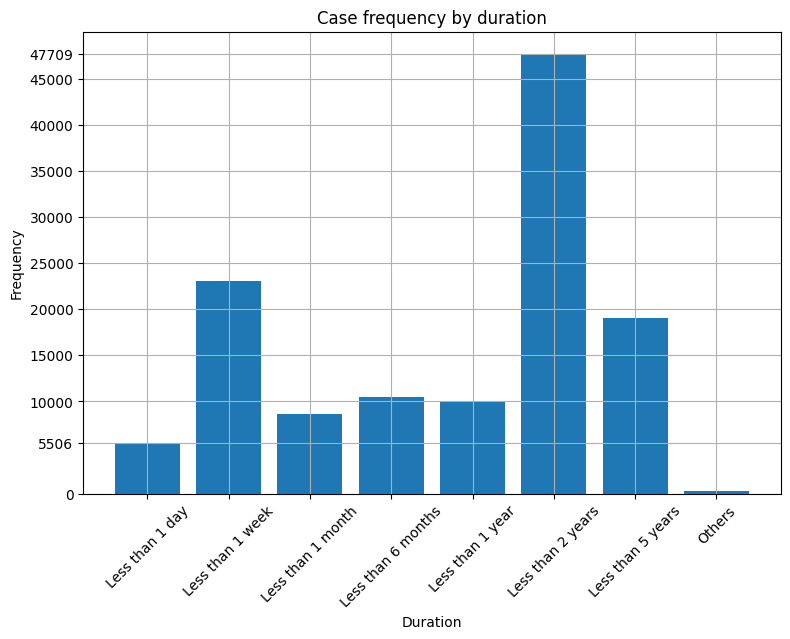

In [140]:
xlabels = ["Less than 1 day",
            "Less than 1 week",
            "Less than 1 month",
            "Less than 6 months",
            "Less than 1 year",
            "Less than 2 years",
            "Less than 5 years",
            "Others"]
freqs = [len(case_durations_df[case_durations_df["Duration"] <= 60*60*24]), # 1 day
            len(case_durations_df[case_durations_df["Duration"] <= 60*60*24 * 7]), # 1 week
            len(case_durations_df[case_durations_df["Duration"] <= 60*60*24*7 * 4]), # 1 month
            len(case_durations_df[case_durations_df["Duration"] <= 60*60*24*7*4 * 6]), # 6 months
            len(case_durations_df[case_durations_df["Duration"] <= 60*60*24 * 365]), # 1 year
            len(case_durations_df[case_durations_df["Duration"] <= 60*60*24*365 * 2]), # 2 years
            len(case_durations_df[case_durations_df["Duration"] <= 60*60*24*365 * 5]), # 5 years
            len(case_durations_df)]

for x in range(len(freqs)-1, 0, -1):
    freqs[x] -= freqs[x-1]

for x in range(len(freqs)):
    print(f"{xlabels[x].ljust(20, ' ')}: {str(freqs[x]).ljust(5, ' ')} ({round(freqs[x]/len(case_durations_df) * 100, 2)}%)")

plt.figure(figsize=(9, 6))
plt.bar(xlabels, freqs)
plt.xlabel("Duration")
plt.ylabel("Frequency")
plt.title("Case frequency by duration")

y_custom_ticks = [x*5000 for x in range(10)]
y_custom_ticks.remove(5000)
y_custom_ticks.append(min(freqs[:len(freqs)-1]))
y_custom_ticks.append(max(freqs))
y_custom_ticks.sort()

plt.yticks(y_custom_ticks)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [141]:
print(pm4py.get_end_activities(filtered_log))

end_acts = pm4py.get_end_activities(filtered_log)
x_axis = []
y_axis = []

for i in end_acts.keys():
    x_axis.append(i)
    y_axis.append(end_acts[i])

others_amount = end_acts["Appeal to Judge"]+end_acts["Send for Credit Collection"]+end_acts["Send Appeal to Prefecture"]
print(f"Payments: {end_acts['Payment']}")
print(f"Others: {others_amount}")

{'Send for Credit Collection': 58997, 'Payment': 62399, 'Send Appeal to Prefecture': 3140, 'Appeal to Judge': 134}
Payments: 62399
Others: 62271


In [142]:
paid_cases = pm4py.filter_end_activities(filtered_log, ['Payment'])
unpaid_cases = pm4py.filter_end_activities(filtered_log, ['Payment'], retain=False)

# print(f"Paid fine min: {paid_cases[paid_cases['concept:name'] == 'Create Fine']['amount'].min()}")
# print(f"Paid fine max: {paid_cases[paid_cases['concept:name'] == 'Create Fine']['amount'].max()}")
# print(f"Paid fine mean: {paid_cases[paid_cases['concept:name'] == 'Create Fine']['amount'].mean()}")

# print(f"Unpaid fine min: {unpaid_cases[unpaid_cases['concept:name'] == 'Create Fine']['amount'].min()}")
# print(f"Unpaid fine max: {unpaid_cases[unpaid_cases['concept:name'] == 'Create Fine']['amount'].max()}")
# print(f"Unpaid fine mean: {unpaid_cases[unpaid_cases['concept:name'] == 'Create Fine']['amount'].mean()}")

# paid_cases.head(10)

In [143]:
paid_ids = paid_cases["case:concept:name"].unique().tolist()
unpaid_ids = unpaid_cases["case:concept:name"].unique().tolist()

paid_durations = pm4py.filter_event_attribute_values(case_durations_df, "case:concept:name", paid_ids) #case_durations_df[case_durations_df["case:concept:name"] in paid_ids]
unpaid_durations = pm4py.filter_event_attribute_values(case_durations_df, "case:concept:name", unpaid_ids) #case_durations_df[case_durations_df["case:concept:name"] in unpaid_ids]

# for c in paid_ids:
#     # print(c)
#     a = case_durations_df[case_durations_df["case:concept:name"] == c]
#     print(a.iloc[0]["Duration"])

print(f"Paid min duration: {paid_durations['Duration'].min()}")
print(f"Paid max duration: {paid_durations['Duration'].max()}")
print(f"Paid mean duration: {paid_durations['Duration'].mean()}")

print(f"Paid min duration: {unpaid_durations['Duration'].min()}")
print(f"Paid max duration: {unpaid_durations['Duration'].max()}")
print(f"Paid mean duration: {unpaid_durations['Duration'].mean()}")

# plt.figure(figsize=(9, 6))
# plt.bar(["Paid", "Others"], [paid_durations['Duration'].mean()/(60*60*24), unpaid_durations['Duration'].mean()/(60*60*24)], width=0.4)
# # plt.xlabel("Duration")
# plt.ylabel("Duration (days)")
# # plt.title("Case frequency by duration")
# plt.show()

Paid min duration: 86400
Paid max duration: 180230400
Paid mean duration: 9984463.699738778
Paid min duration: 3456000
Paid max duration: 377740800
Paid mean duration: 58452367.33632028


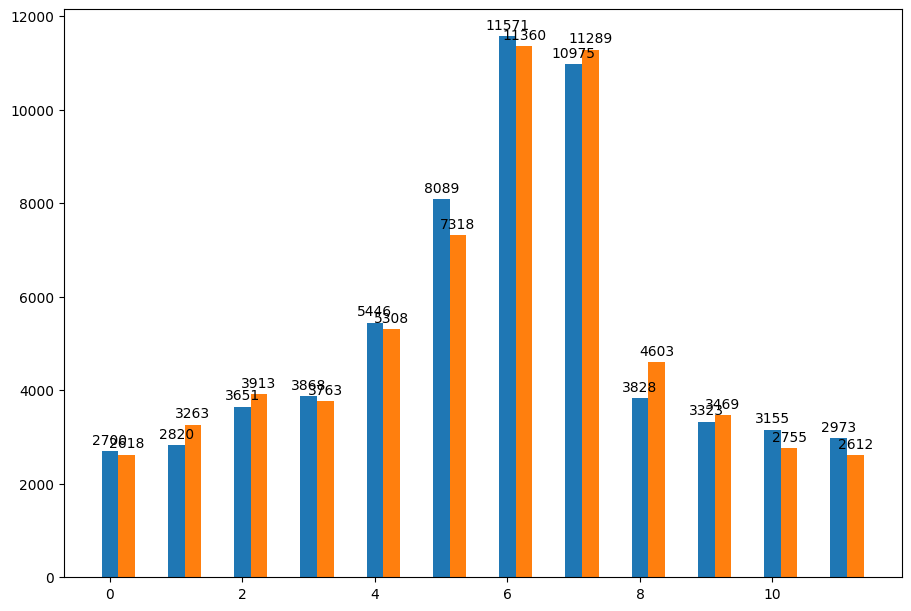

In [144]:
months = [int(x) for x in case_durations_df["StartMonth"].unique().tolist()]
months.sort()

paid_case_durations = pm4py.filter_event_attribute_values(case_durations_df, "case:concept:name", paid_cases["case:concept:name"].unique().tolist())

paid_amounts = []
for x in months:
    filtered_durations = paid_case_durations[paid_case_durations["StartMonth"] == x]
    paid_amounts.append(len(filtered_durations))

unpaid_case_durations = pm4py.filter_event_attribute_values(case_durations_df, "case:concept:name", unpaid_cases["case:concept:name"].unique().tolist())

unpaid_amounts = []
for x in months:
    filtered_durations = unpaid_case_durations[unpaid_case_durations["StartMonth"] == x]
    unpaid_amounts.append(len(filtered_durations))

months_labels = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

amounts_dict = {
    'Paid': paid_amounts,
    'Unpaid': unpaid_amounts,
}

x = np.arange(len(months))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(9, 6))

for attribute, measurement in amounts_dict.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

plt.show()

In [145]:
# tolgo le varianti senza invio della multa perché non fanno parte della correlazione che cerco
log_new_paid = pm4py.filter_variants(paid_cases, [('Create Fine', 'Payment')], retain=False)

# Filter rows for 'Create Fine' and 'Send Fine'
create_fine_df = log_new_paid[log_new_paid['concept:name'] == 'Create Fine']
send_fine_df = log_new_paid[log_new_paid['concept:name'] == 'Send Fine']

# Merge the two DataFrames on 'case:concept:name'
merged_df = pd.merge(create_fine_df, send_fine_df, on='case:concept:name', suffixes=('_create', '_send'))

time_differences_paid = (merged_df['time:timestamp_send'] - merged_df['time:timestamp_create']).tolist()

print(f"Paid timeliness min: {min(time_differences_paid)}")
print(f"Paid timeliness max: {max(time_differences_paid)}")
paid_mean = sum([int(x.total_seconds()) for x in time_differences_paid])/len(time_differences_paid)
print(f"Paid timeliness mean: {paid_mean}")

# plt.figure(figsize=(9, 6))
# plt.scatter(range(len(time_differences_paid)), [int(x.total_seconds()) for x in time_differences_paid])
# plt.xlabel('Case')
# plt.ylabel('Notification timeliness')
# plt.title('Scatter Plot of Notification timeliness (paid)')
# plt.grid(True)
# plt.show()

Paid timeliness min: 0 days 00:00:00
Paid timeliness max: 732 days 00:00:00
Paid timeliness mean: 7586613.19240932


In [146]:
# Filter rows for 'Create Fine' and 'Send Fine'
create_fine_df = unpaid_cases[unpaid_cases['concept:name'] == 'Create Fine']
send_fine_df = unpaid_cases[unpaid_cases['concept:name'] == 'Send Fine']

# Merge the two DataFrames on 'case:concept:name'
merged_df = pd.merge(create_fine_df, send_fine_df, on='case:concept:name', suffixes=('_create', '_send'))

time_differences_unpaid = (merged_df['time:timestamp_send'] - merged_df['time:timestamp_create']).tolist()

print(f"Unpaid timeliness min: {min(time_differences_unpaid)}")
print(f"Unpaid timeliness max: {max(time_differences_unpaid)}")
unpaid_mean = sum([int(x.total_seconds()) for x in time_differences_unpaid])/len(time_differences_unpaid)
print(f"Unpaid timeliness mean: {unpaid_mean}")

# plt.figure(figsize=(9, 6))
# plt.scatter(range(len(time_differences_unpaid)), [int(x.total_seconds()) for x in time_differences_unpaid])
# plt.xlabel('Case')
# plt.ylabel('Notification timeliness')
# plt.title('Scatter Plot of Notification timeliness (unpaid)')
# plt.grid(True)
# plt.show()

Unpaid timeliness min: 0 days 00:00:00
Unpaid timeliness max: 593 days 00:00:00
Unpaid timeliness mean: 7296901.238335394


In [147]:
from scipy.stats import ttest_ind

t_stat, p_val = ttest_ind([int(x.total_seconds()) for x in time_differences_paid], [int(x.total_seconds()) for x in time_differences_unpaid], equal_var=False)

print(f"T-stat: {t_stat}\nP-value: {p_val}")

T-stat: 9.928369333950219
P-value: 3.3586386693449295e-23


## Process discover

In [148]:
# def print_top_variants_info(input_log, k=5):
#     filtered_log_top = pm4py.filter_variants_top_k(input_log, k)

#     num_events = len(filtered_log)
#     num_events_top = len(filtered_log_top)
#     num_cases = len(filtered_log['case:concept:name'].unique())
#     num_cases_top = len(filtered_log_top['case:concept:name'].unique())
#     print(f"Number of events: {num_events_top}/{num_events} ({round(num_events_top/num_events * 100, 2)}%)")
#     print(f"Number of cases: {num_cases_top}/{num_cases} ({round(num_cases_top/num_cases * 100, 2)}%)")

#     net, im, fm = pm4py.discover_petri_net_inductive(filtered_log_top)
#     pm4py.view_petri_net(net, im, fm, format='png')

In [149]:
# print_top_variants_info(filtered_log, 1)

In [150]:
# print_top_variants_info(filtered_log, 3)

In [151]:
# print_top_variants_info(filtered_log, 5)

In [152]:
# print_top_variants_info(filtered_log, 10)